
Year: 2015 — A(t):
                 Bombus  Flavipanurgus  Dasypoda  Xylocopa  Lasioglossum
Bombus        -0.05822       -0.02377  -0.06718  -0.01141       0.07155
Flavipanurgus -0.03824       -0.16063   0.10077   0.01001       0.18636
Dasypoda       0.04940       -0.03136  -0.33388  -0.02503       0.16665
Xylocopa       0.08180        0.00819  -0.14835  -0.02604      -0.24292
Lasioglossum   0.01707        0.00390   0.19226  -0.07698      -0.52978
Thresholds — Positive: 0.0692, Negative: 0.0715

Year: 2016 — A(t):
                 Bombus  Flavipanurgus  Dasypoda  Xylocopa  Lasioglossum
Bombus        -0.24445        0.00650   0.04587   0.07713       0.44245
Flavipanurgus -0.60561       -0.11465  -0.18393   0.08483       0.25271
Dasypoda       0.10487        0.04622  -0.36642   0.02007      -0.28856
Xylocopa       0.28530        0.08606  -0.24869  -0.12835      -0.58374
Lasioglossum   0.03244        0.08050  -0.14370  -0.03528      -0.65296
Thresholds — Positive: 0.1229, Negative: 0.201

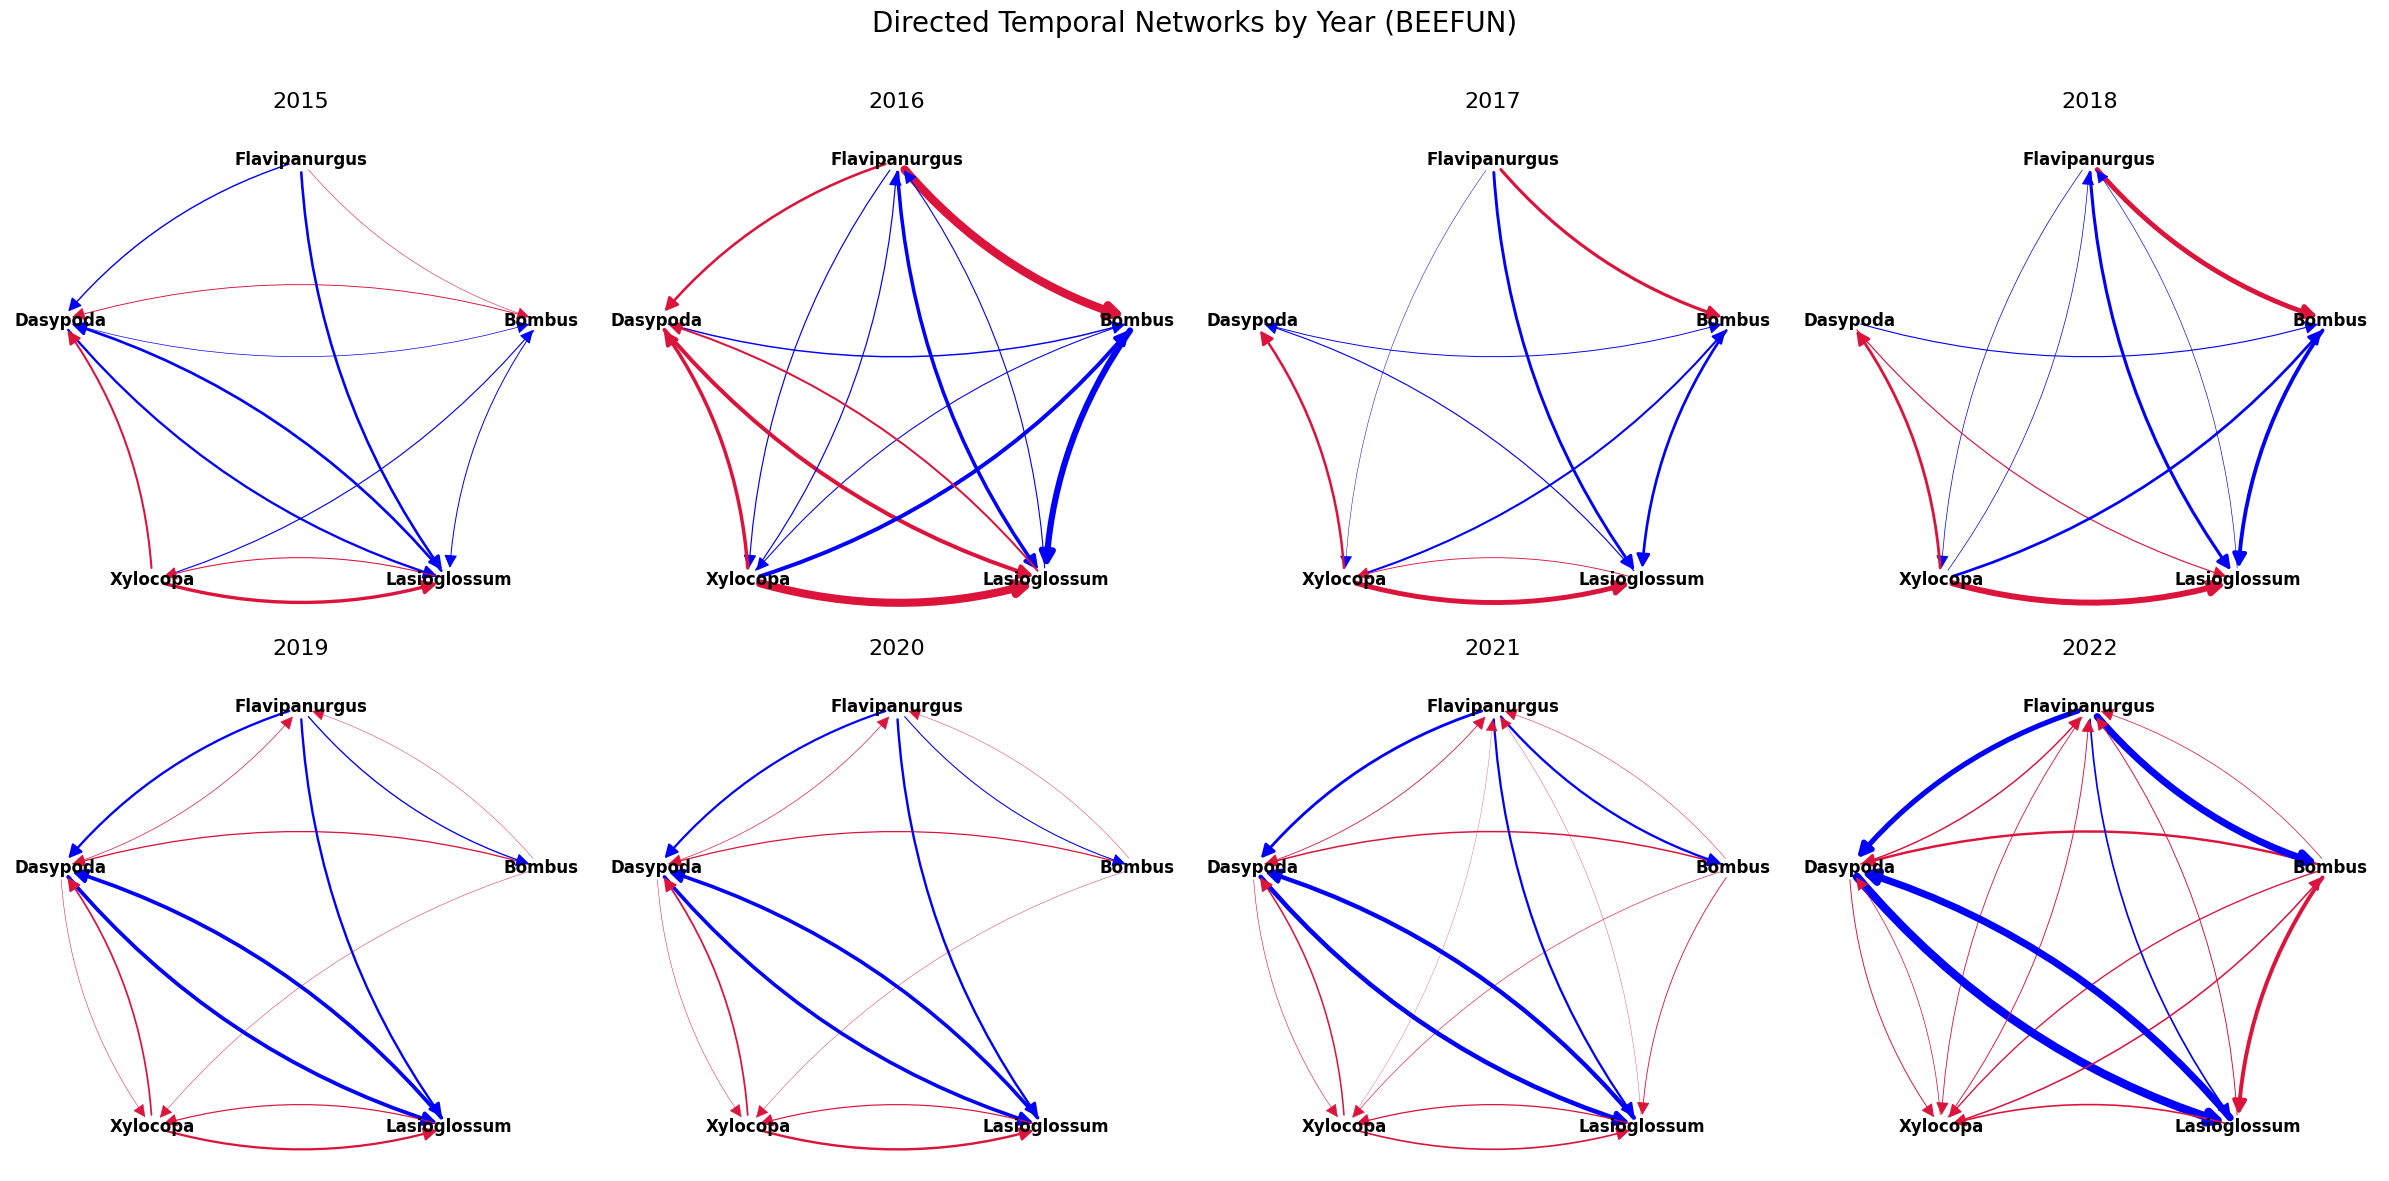

In [47]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math

# === PARAMETERS ===
folder_path = 'BEEFUN'
layout_seed = 42
years = list(range(2015, 2023))  # 2015 to 2022, change for each dataset

# === LOAD MATRIX FUNCTION ===
def load_matrix_and_labels(path):
    df = pd.read_csv(path, index_col=0)
    labels = list(df.columns)
    matrix = df.to_numpy(dtype=float)
    return matrix, labels

# === LOAD DATA ===
A, labels = load_matrix_and_labels(os.path.join(folder_path, 'matrix_A.csv'))
B, _ = load_matrix_and_labels(os.path.join(folder_path, 'matrix_B.csv'))
P = pd.read_csv(os.path.join(folder_path, 'rainfall_bee.csv'), header=0).to_numpy(dtype=float).flatten()

# === CHECKS ===
assert A.shape == B.shape, f"A and B must have the same shape. Got {A.shape} and {B.shape}"
assert len(labels) == A.shape[0], "Label count must match matrix dimensions"
assert len(P) == len(years), "P(t) length must match number of years"

# === CUSTOM CLOCKWISE NODE POSITIONS STARTING FROM FLAVIPANURGUS ===
custom_order = ["Flavipanurgus", "Bombus", "Lasioglossum", "Xylocopa", "Dasypoda"]
angle_step = 2 * np.pi / len(custom_order)
angles = [np.pi / 2 - i * angle_step for i in range(len(custom_order))]  # Start at top
pos = {label: (np.cos(angle), np.sin(angle)) for label, angle in zip(custom_order, angles)}

# === Initialize storage ===
average_weights = []
all_links = [(u, v) for i, u in enumerate(labels) for j, v in enumerate(labels) if i != j]
link_labels = [f"{u} → {v}" for u, v in all_links]
weight_matrix = pd.DataFrame(np.nan, index=link_labels, columns=years)

# === Prepare subplot grid ===
n_years = len(years)
n_cols = 4
n_rows = math.ceil(n_years / n_cols)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows))
axs = axs.flatten()

# === TEMPORAL NETWORK LOOP ===
for idx, (year, p_t) in enumerate(zip(years, P)):
    # --- Compute A_t for the current year ---
    A_t = A + B * p_t
    A_t_df = pd.DataFrame(A_t, index=labels, columns=labels)
    print(f"\nYear: {year} — A(t):\n", A_t_df.round(5))
    
    # --- Extract off-diagonal values ---
    off_diag_mask = ~np.eye(A_t.shape[0], dtype=bool)
    A_off_diag = A_t[off_diag_mask]
    
    # --- Compute separate thresholds for positive and negative values ---
    positive_values = A_off_diag[A_off_diag > 0]
    negative_values = A_off_diag[A_off_diag < 0]
    
    pos_threshold = np.std(positive_values) if len(positive_values) > 0 else 0
    neg_threshold = np.std(negative_values) if len(negative_values) > 0 else 0
    
    print(f"Thresholds — Positive: {pos_threshold:.4f}, Negative: {neg_threshold:.4f}")
    
    # --- Build thresholded directed interaction graph ---
    G_t = nx.DiGraph()
    G_t.add_nodes_from(labels)
    
    for i, u in enumerate(labels):
        for j, v in enumerate(labels):
            if i == j:
                continue
            weight = A_t[i, j]
    
            # Apply asymmetric thresholding based on sign
            if (weight > 0 and weight > pos_threshold/2) or (weight < 0 and abs(weight) > abs(neg_threshold/2)):
                G_t.add_edge(u, v, weight=weight)
                weight_matrix.at[f"{u} → {v}", year] = weight


    # === SUBPLOT ===
    ax = axs[idx]
    ax.set_title(f"{year}", fontsize=16)
    nx.draw_networkx_labels(G_t, pos, font_size=12, font_weight='bold', ax=ax)
    edges = G_t.edges(data=True)
    edge_weights = [abs(d['weight']) for (_, _, d) in edges]
    edge_colors = ['blue' if d['weight'] >= 0 else 'crimson' for (_, _, d) in edges]

    nx.draw_networkx_edges(
        G_t, pos,
        ax=ax,
        arrows=True,
        edge_color=edge_colors,
        width=[w * 10 for w in edge_weights],
        connectionstyle='arc3,rad=0.15',
        arrowsize=20
    )
    ax.axis('off')
# Hide unused subplots
for i in range(n_years, len(axs)):
    axs[i].axis('off')

plt.suptitle("Directed Temporal Networks by Year (BEEFUN)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
#plt.savefig('matrices_bees.pdf')
plt.show()



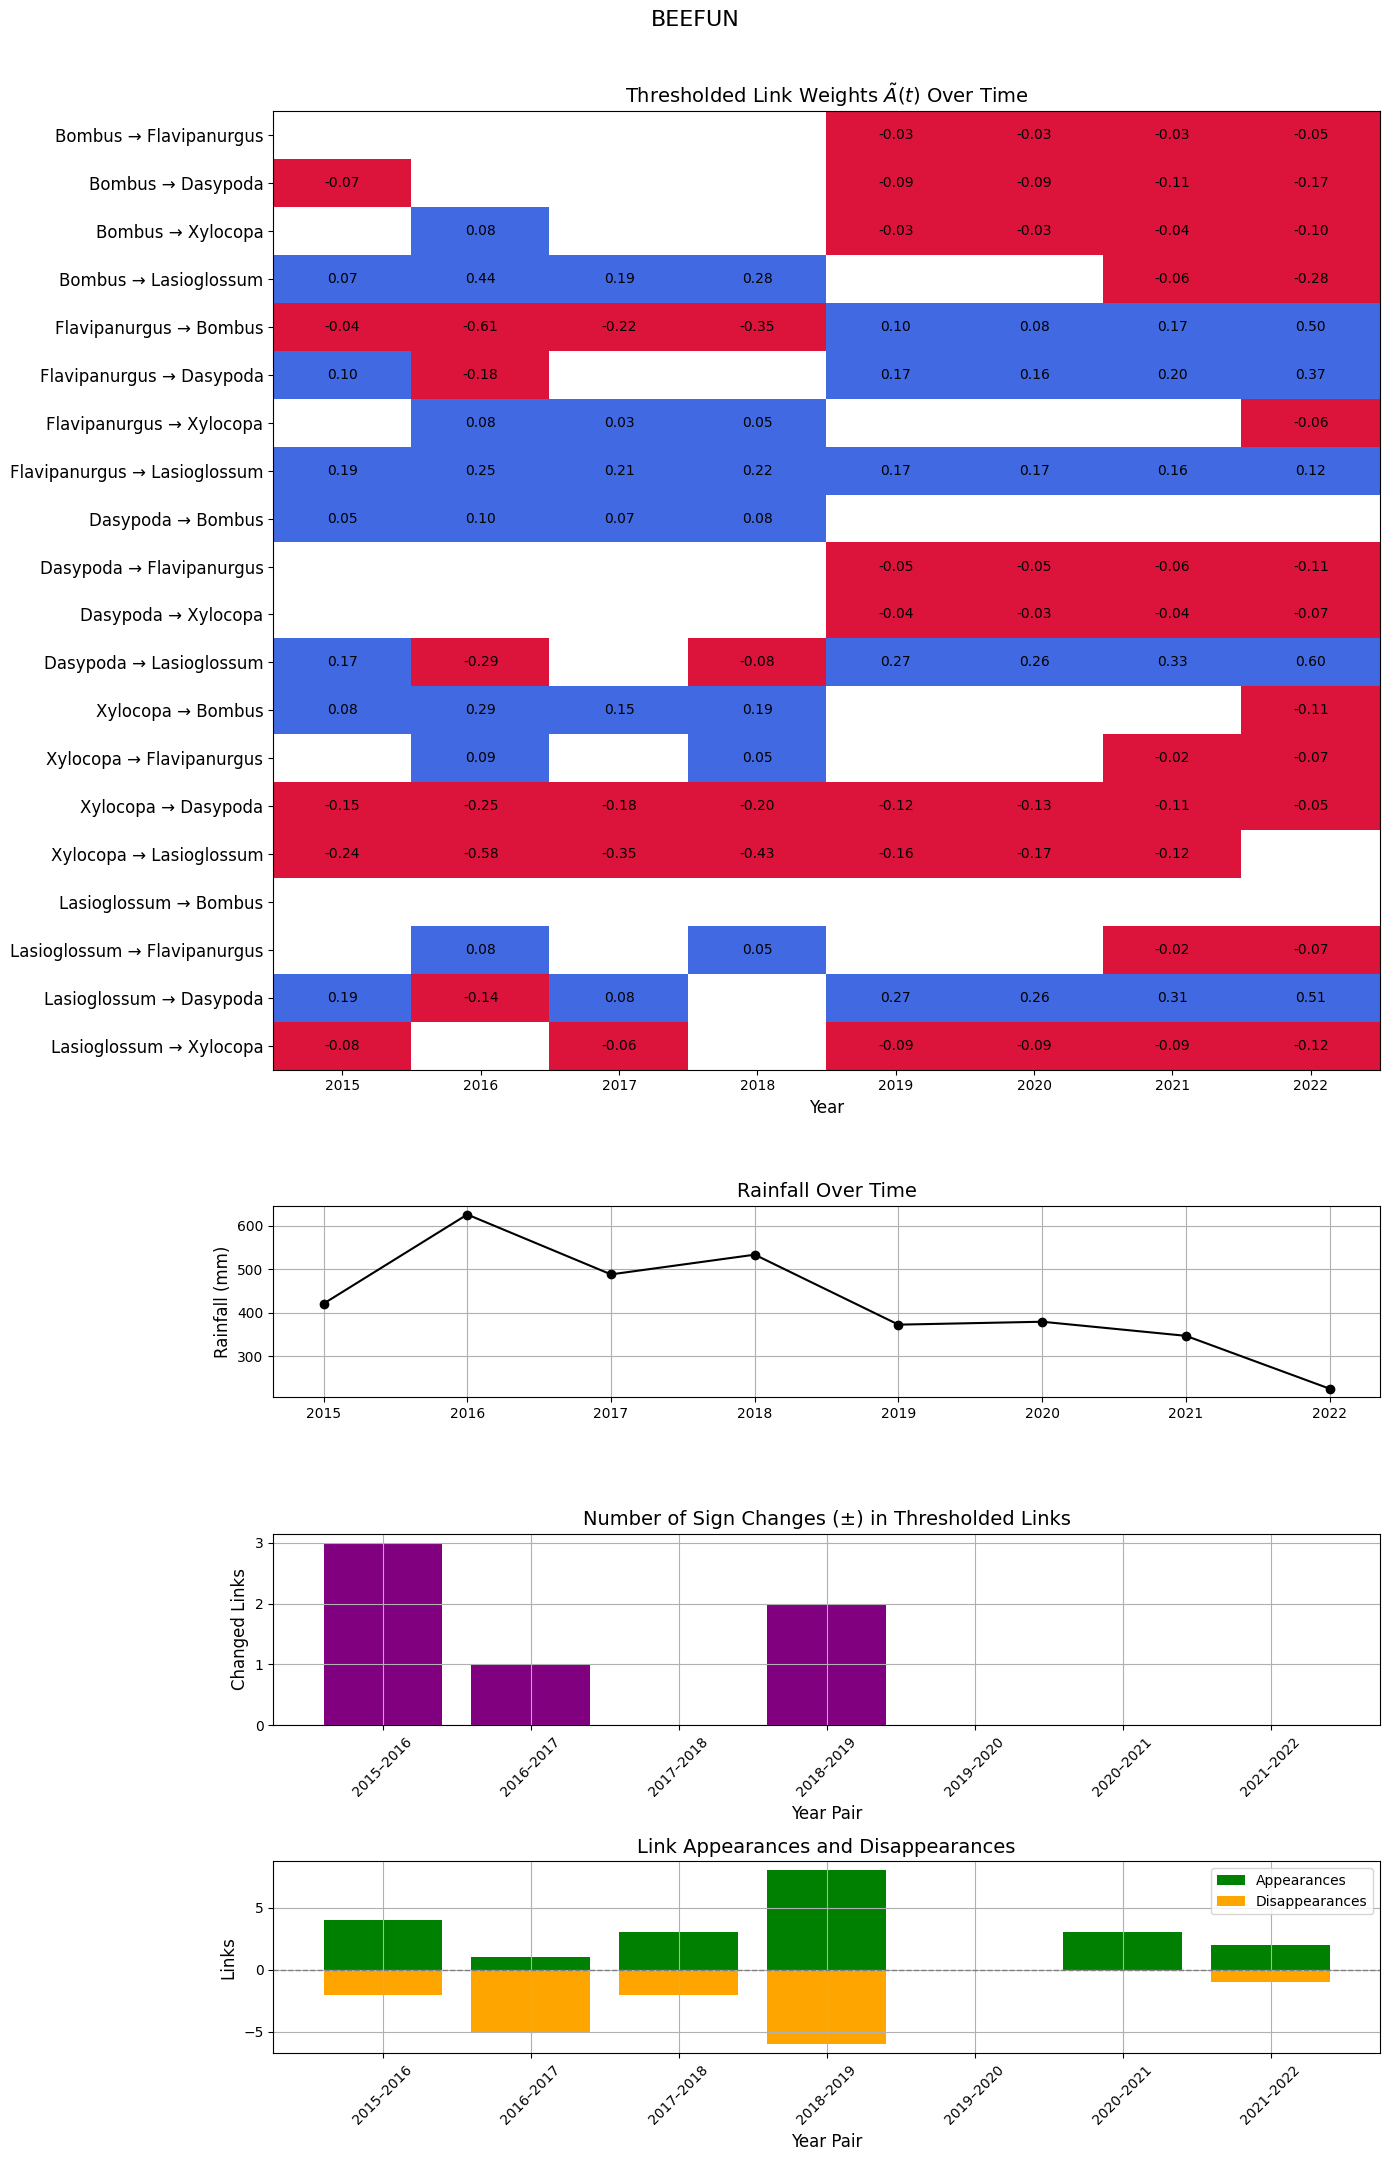

In [48]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# === PREP ===
year_pairs = [f"{years[i]}–{years[i+1]}" for i in range(len(years) - 1)]
P_jumps = P[1:] - P[:-1]

# === Compute metrics ===
sign_change_counts = [0]
previous_signs = weight_matrix[years[0]].apply(np.sign)
for y in years[1:]:
    current_signs = weight_matrix[y].apply(np.sign)
    changes = (current_signs != previous_signs) & ~(current_signs.isna() | previous_signs.isna())
    sign_change_counts.append(changes.sum())
    previous_signs = current_signs

appearance_counts = [0]
disappearance_counts = [0]
prev_active = weight_matrix[years[0]].notna()
for y in years[1:]:
    curr_active = weight_matrix[y].notna()
    appearance = curr_active & ~prev_active
    disappearance = ~curr_active & prev_active
    appearance_counts.append(appearance.sum())
    disappearance_counts.append(disappearance.sum())
    prev_active = curr_active

fraction_positive_links = []
for y in years:
    col = weight_matrix[y].dropna()
    pos_fraction = (col > 0).sum() / len(col) if len(col) else 0
    fraction_positive_links.append(pos_fraction)

# === PLOTTING ===
fig, axs = plt.subplots(4, 1, figsize=(14, 22), gridspec_kw={'height_ratios': [5, 1, 1, 1]})
fig.suptitle('BEEFUN', fontsize=16)

# --- 1. Heatmap ---
color_matrix = weight_matrix.copy()
color_matrix[color_matrix > 0] = 1
color_matrix[color_matrix < 0] = -1

cmap = mcolors.ListedColormap(['crimson', 'white', 'royalblue'])  # -1, 0, +1
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

axs[0].imshow(color_matrix.values, aspect='auto', cmap=cmap, norm=norm)

# Annotate weights
for i, row in enumerate(weight_matrix.values):
    for j, val in enumerate(row):
        if not np.isnan(val):
            axs[0].text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=10, color='black')

axs[0].set_yticks(np.arange(len(link_labels)))
axs[0].set_yticklabels(link_labels, fontsize=12)
axs[0].set_xticks(np.arange(len(years)))
axs[0].set_xticklabels(years)
axs[0].set_title("Thresholded Link Weights $\\tilde{A}(t)$ Over Time", fontsize=14)
axs[0].set_xlabel("Year", fontsize=12)

# --- 2. Rainfall Plot now here ---
axs[1].plot(years, P, marker='o', color='black')
axs[1].set_title("Rainfall Over Time", fontsize=14)
axs[1].set_ylabel("Rainfall (mm)", fontsize=12)
axs[1].grid(True)
axs[1].set_xticks(years)

# --- 3. Sign Change Count ---
axs[2].bar(year_pairs, sign_change_counts[1:], color='purple')
axs[2].set_title("Number of Sign Changes (±) in Thresholded Links", fontsize=14)
axs[2].set_ylabel("Changed Links", fontsize=12)
axs[2].set_xlabel("Year Pair", fontsize=12)
axs[2].set_xticks(np.arange(len(year_pairs)))
axs[2].set_xticklabels(year_pairs, rotation=45)
axs[2].grid(True)

# --- 4. Appearance/Disappearance ---
axs[3].bar(np.arange(len(year_pairs)), appearance_counts[1:], color='green', label='Appearances')
axs[3].bar(np.arange(len(year_pairs)), [-d for d in disappearance_counts[1:]], color='orange', label='Disappearances')
axs[3].axhline(0, color='gray', linestyle='--', linewidth=1)
axs[3].set_title("Link Appearances and Disappearances", fontsize=14)
axs[3].set_ylabel("Links", fontsize=12)
axs[3].set_xlabel("Year Pair", fontsize=12)
axs[3].set_xticks(np.arange(len(year_pairs)))
axs[3].set_xticklabels(year_pairs, rotation=45)
axs[3].legend()
axs[3].grid(True)

# Final layout
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('Links_bees.pdf', dpi=300)
plt.show()



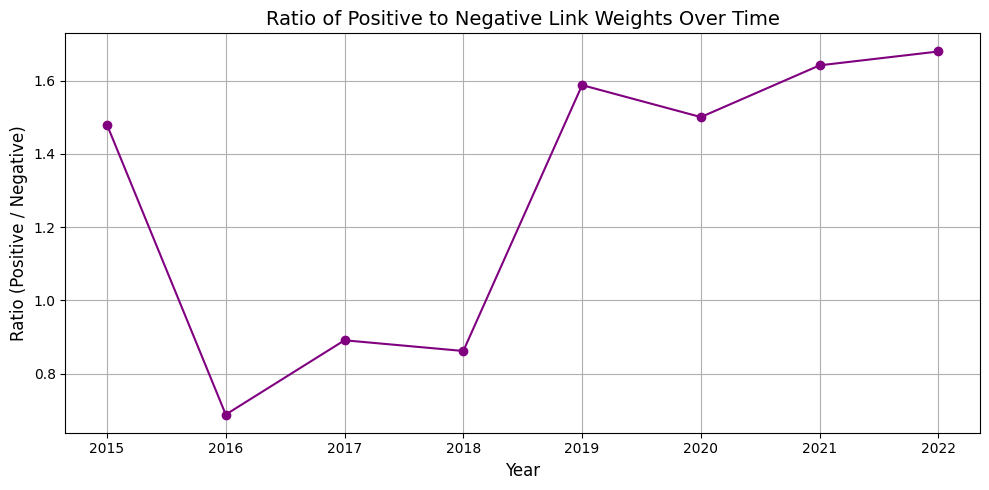

In [51]:
# === Compute ratio of positive to negative weights over time ===

years = list(weight_matrix.columns)
pos_neg_ratios = []
total_positives = []
total_negatives = []

for year in years:
    col = weight_matrix[year].dropna()
    pos_weights = col[col > 0]
    neg_weights = col[col < 0]

    pos_sum = pos_weights.sum()
    neg_sum = np.abs(neg_weights.sum())  # take absolute value for ratio

    total_positives.append(pos_sum)
    total_negatives.append(neg_sum)

    if neg_sum > 0:
        ratio = pos_sum / neg_sum
    else:
        ratio = np.inf  # handle division by zero gracefully

    pos_neg_ratios.append(ratio)

# === Plot ===
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(years, pos_neg_ratios, marker='o', color='purple')
ax.set_title("Ratio of Positive to Negative Link Weights Over Time", fontsize=14)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Ratio (Positive / Negative)", fontsize=12)
ax.grid(True)

plt.tight_layout()
plt.show()



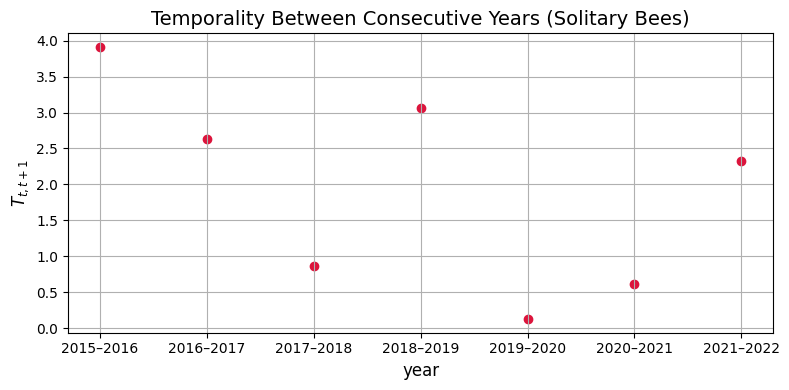

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def temporality_T(A_m, A_n):
    A_m = np.array(A_m)
    A_n = np.array(A_n)
    
    numerator = np.sum(np.abs(A_m - A_n))
    denominator = np.sum(np.maximum(A_m, A_n))
    
    return numerator #/ denominator if denominator != 0 else 0

# Define your list of years
years = list(range(2015, 2023))  # 2015 to 2022

# Generate time-evolving adjacency matrices
A_t = [A + B * p_t for p_t in P]

# Compute temporality between consecutive years
T_consecutive = []
for i in range(len(A_t) - 1):
    T_consecutive.append(temporality_T(A_t[i], A_t[i + 1]))

# Corresponding x-axis: midpoints between years
year_pairs = [f"{years[i]}–{years[i+1]}" for i in range(len(years) - 1)]
P_jumps=P[1:]-P[0:len(P)-1]
# Plot the result
plt.figure(figsize=(8, 4))
plt.scatter( year_pairs, T_consecutive, marker='o', linestyle='-', color='crimson')

plt.title("Temporality Between Consecutive Years (Solitary Bees)", fontsize=14)
plt.ylabel("$T_{t,t+1}$", fontsize=12)
plt.xlabel("year", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.tight_layout()
plt.savefig('Temporality_bees.pdf')
plt.show() 


/home/annalisa/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Roboto.
  fig.canvas.print_figure(bytes_io, **kw)


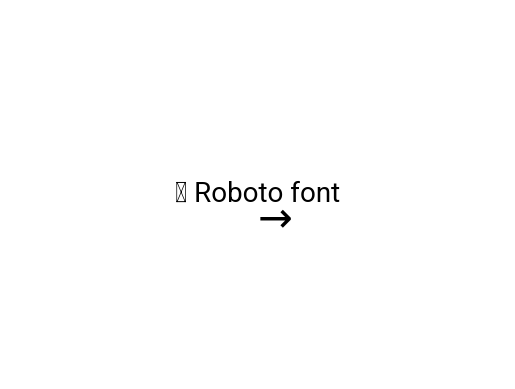

/tmp/ipykernel_26477/2224622733.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


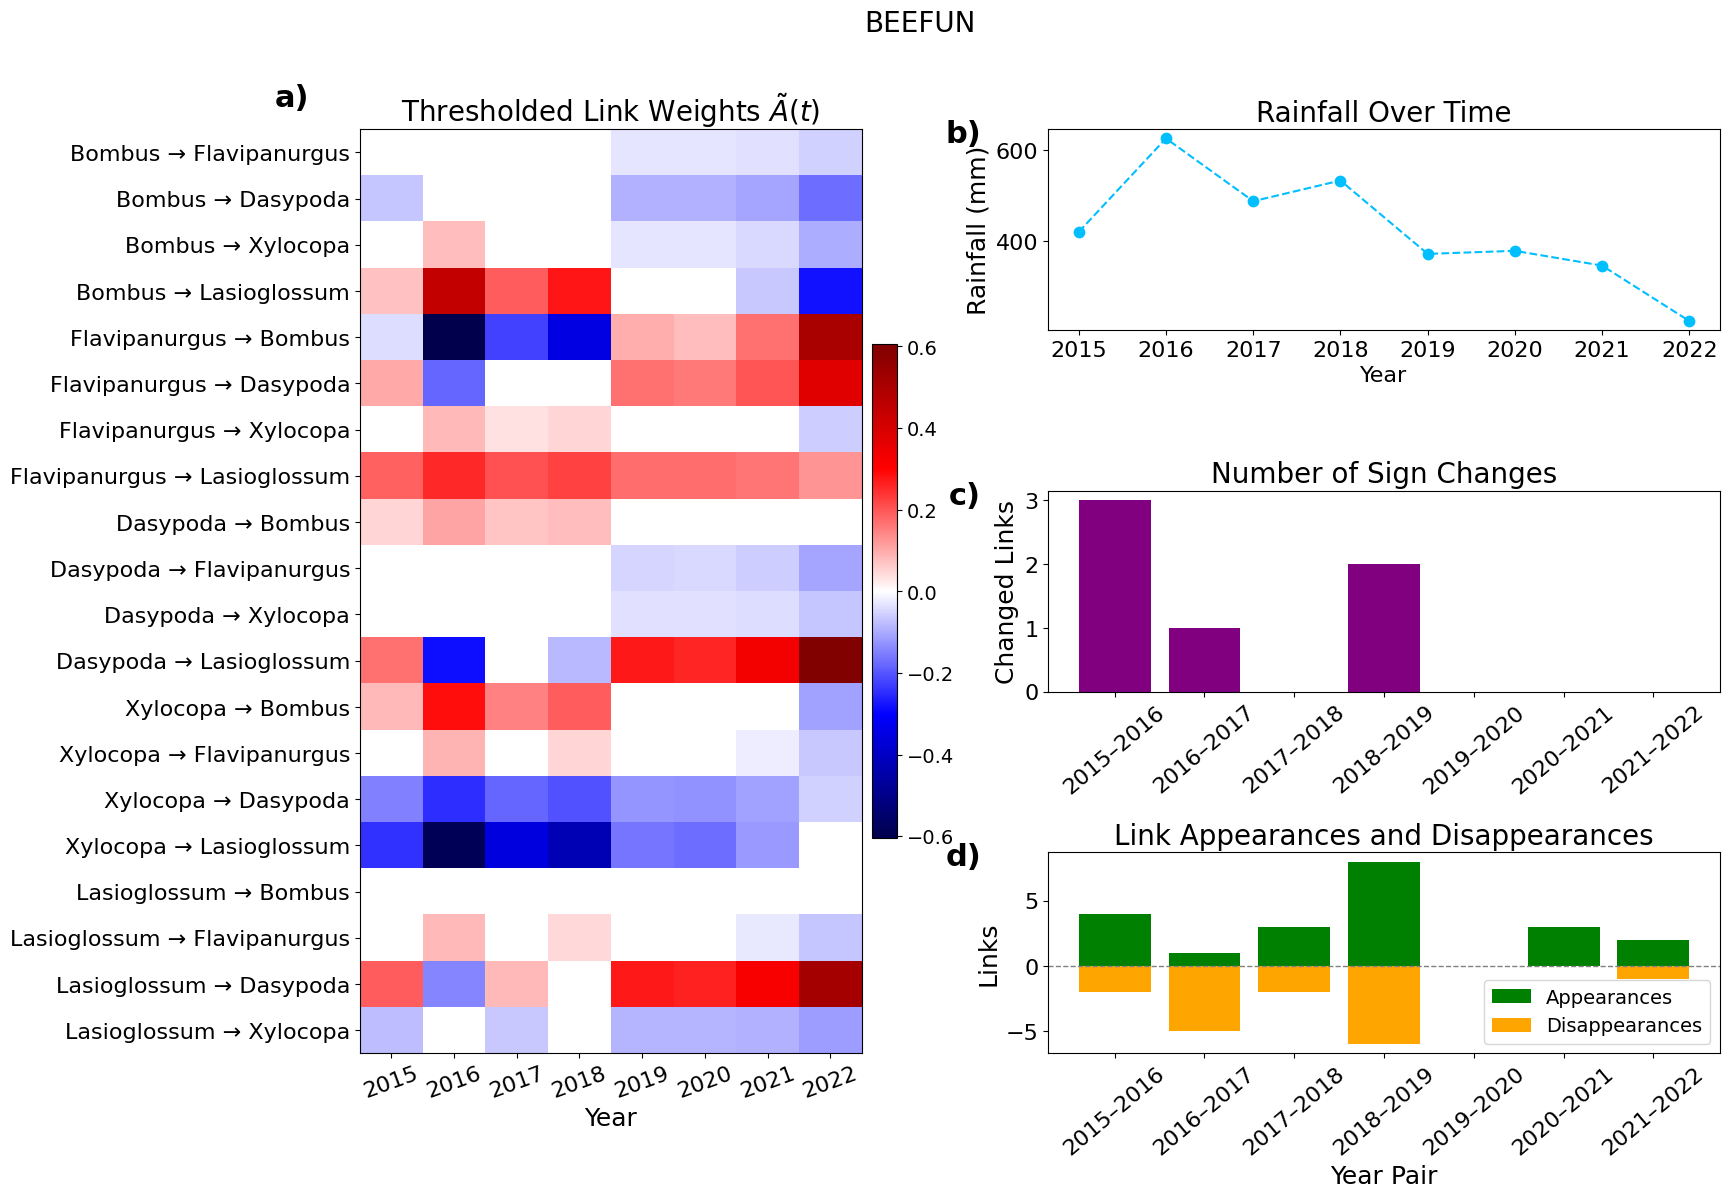

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as fm

# Use default style
plt.style.use('default')

# Load Roboto font from local file
font_path = 'Roboto.ttf'  # Make sure the path is correct
roboto = fm.FontProperties(fname=font_path)

# Now use it explicitly where needed
plt.figure()
plt.text(0.5, 0.5, '→ Roboto font', fontproperties=roboto, fontsize=20, ha='center', va='center')
# Use Roboto for the text and default for the arrow

plt.text(0.5, 0.4, '→', fontsize=30)  # will use DejaVu Sans

plt.axis('off')
plt.show()

# === PREP ===
year_pairs = [f"{years[i]}–{years[i+1]}" for i in range(len(years) - 1)]
P_jumps = P[1:] - P[:-1]

# === Compute metrics ===
sign_change_counts = [0]
previous_signs = weight_matrix[years[0]].apply(np.sign)
for y in years[1:]:
    current_signs = weight_matrix[y].apply(np.sign)
    changes = (current_signs != previous_signs) & ~(current_signs.isna() | previous_signs.isna())
    sign_change_counts.append(changes.sum())
    previous_signs = current_signs

appearance_counts = [0]
disappearance_counts = [0]
prev_active = weight_matrix[years[0]].notna()
for y in years[1:]:
    curr_active = weight_matrix[y].notna()
    appearance = curr_active & ~prev_active
    disappearance = ~curr_active & prev_active
    appearance_counts.append(appearance.sum())
    disappearance_counts.append(disappearance.sum())
    prev_active = curr_active

fraction_positive_links = []
for y in years:
    col = weight_matrix[y].dropna()
    pos_fraction = (col > 0).sum() / len(col) if len(col) else 0
    fraction_positive_links.append(pos_fraction)

# === PLOTTING ===
fig = plt.figure(figsize=(20, 12))
gs = GridSpec(3, 2, width_ratios=[2, 2.5], height_ratios=[1, 1, 1], wspace=0.25, hspace=0.8)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
fig.suptitle('BEEFUN', fontsize=20)
#plt.tick_params(labelsize=20)
plt.subplots_adjust(left=0.22)  # Increase left margin (default is ~0.125)

# --- Heatmap (izquierda) ---
ax0 = fig.add_subplot(gs[:, 0])

# Binarizar para color
color_matrix = weight_matrix.copy()
color_matrix[color_matrix > 0] = 1
color_matrix[color_matrix < 0] = -1

cmap = mcolors.ListedColormap(['crimson', 'white', 'royalblue'])  # -1, 0, +1
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

color_matrix = weight_matrix.copy()

# Crear colormap continuo rojo-blanco-azul
cmap = plt.get_cmap('seismic')  # Alternativas: 'coolwarm', 'bwr', etc.

# Centrar en 0 (simetría rojo-negativo / azul-positivo)
vmin = -np.nanmax(np.abs(color_matrix.values))
vmax = -vmin  # Simetría
im = ax0.imshow(color_matrix.values, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)

# Sin anotaciones
ax0.set_yticks(np.arange(len(link_labels)))
ax0.set_yticklabels(link_labels, fontsize=16)
ax0.set_xticks(np.arange(len(years)))
ax0.set_xticklabels(years, rotation=20, fontsize=16)
ax0.set_title("Thresholded Link Weights $\\tilde{A}(t)$", fontsize=20)
ax0.set_xlabel("Year", fontsize=18)
cbar = fig.colorbar(im, ax=ax0, orientation='vertical', fraction=0.046, pad=0.02)
cbar.ax.tick_params(labelsize=14)
# --- 2. Rainfall ---
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(years, P, color='deepskyblue', ls='--')
ax1.scatter(years, P, s=90, color='deepskyblue', edgecolors='white')
ax1.set_title("Rainfall Over Time", fontsize=20)
ax1.set_ylabel("Rainfall (mm)", fontsize=18)
ax1.set_xlabel('Year', fontsize=16)


# --- 3. Sign Change Count ---
ax2 = fig.add_subplot(gs[1, 1])
ax2.bar(year_pairs, sign_change_counts[1:], color='purple')
ax2.set_title("Number of Sign Changes", fontsize=20)
ax2.set_ylabel("Changed Links", fontsize=18)
#ax2.set_xlabel("Year Pair", fontsize=16)
ax2.set_xticks(np.arange(len(year_pairs)))
ax2.set_xticklabels(year_pairs, rotation=40)


# --- 4. Appearance/Disappearance ---
ax3 = fig.add_subplot(gs[2, 1])
ax3.bar(np.arange(len(year_pairs)), appearance_counts[1:], color='green', label='Appearances')
ax3.bar(np.arange(len(year_pairs)), [-d for d in disappearance_counts[1:]], color='orange', label='Disappearances')
ax3.axhline(0, color='gray', linestyle='--', linewidth=1)
ax3.set_title("Link Appearances and Disappearances", fontsize=20)
ax3.set_ylabel("Links", fontsize=18)
ax3.set_xlabel("Year Pair", fontsize=18)
ax3.set_xticks(np.arange(len(year_pairs)))
ax3.set_xticklabels(year_pairs, rotation=40)
ax3.legend(fontsize=14, loc='lower right')


# Layout final
plt.tight_layout(rect=[0, 0, 1, 0.95])
#plt.subplots_adjust(left=0.06, right=0.97, top=0.94, bottom=0.08, hspace=0.8, wspace=0.3)
# Panel labels
ax0.text(-0.1, 1.05, 'a)', transform=ax0.transAxes, fontsize=22, fontweight='bold', va='top', ha='right')
ax1.text(-0.1, 1.05, 'b)', transform=ax1.transAxes, fontsize=22, fontweight='bold', va='top', ha='right')
ax2.text(-0.1, 1.05, 'c)', transform=ax2.transAxes, fontsize=22, fontweight='bold', va='top', ha='right')
ax3.text(-0.1, 1.05, 'd)', transform=ax3.transAxes, fontsize=22, fontweight='bold', va='top', ha='right')

plt.savefig('Links_BEEFUN_reordered.pdf', dpi=300)
plt.show()
